Run the code cell below with the ▶| button above to set up this notebook, or type `SHIFT-ENTER`:

In [30]:
!pip install --no-cache-dir -U -q folium
import pandas as pd
import geojson
import geopy
import numpy as np
import matplotlib.pyplot as plt
import folium
from datascience import *
from IPython.display import HTML, display, IFrame
from folium import plugins
%matplotlib inline
from sklearn import linear_model
from scipy import stats
import os
import ipywidgets as widgets
from soc_module import *
import random
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()

from datetime import datetime

# Sociology 130 Module: "The Neighborhood Project"

Welcome to the data science part of your project! You have gathered data and entered it [here](https://goo.gl/forms/eY1mephilS6VqAT83) from your assigned census tracts.  Now it's time to explore our class data and quantify our observations using Python, a popular programming language used in data science. 

You won't need any prior programming knowledge to do this! The purpose of this module is not to teach you programming, but rather to show you the power of these tools and give you the intuition for how they work. It also allows us to quickly produce summarizations of our data!

## Table of Contents

0 - [Python and Jupyter Notebooks](#jupyter)

1 - [Class Data](#yourdata)

2 - [Our Metrics](#ourmetrics)

3 - [Census Data](#census)

4 - [Correlation](#correlation)

5 - [Regression](#regression)

# Part 0: Introduction to Python and Jupyter Notebooks: <a id='jupyter'></a>

## 1. Cells, Arithmetic, and Code
In a notebook, each rectangle containing text or code is called a *cell*.

Cells (like this one) can be edited by double-clicking on them. This cell is a text cell, written in a simple format called [Markdown](http://daringfireball.net/projects/markdown/syntax) to add formatting and section headings.  You don't need to worry about Markdown today, but it's a pretty fun+easy tool to learn.

After you edit a cell, click the "run cell" button at the top that looks like ▶| to confirm any changes. (Try not to delete the instructions.) You can also press `SHIFT-ENTER` to run any cell or progress from one cell to the next.

Other cells contain code in the Python programming language.  Running a code cell will execute all of the code it contains.

Try running this cell:

In [31]:
print("Hello, World!")

Hello, World!


We will now quickly go through some very basic functionality of Python, which we'll be using throughout the rest of this notebook.

### 1.1 Arithmetic
Quantitative information arises everywhere in data science. In addition to representing commands to `print` out lines, expressions can represent numbers and methods of combining numbers. 

The expression `3.2500` evaluates to the number 3.25. (Run the cell and see.)

In [32]:
3.2500

3.25

We don't necessarily always need to say "`print`", because Jupyter always prints the last line in a code cell. If you want to print more than one line, though, do specify "`print`".

In [33]:
print(3)
4
5

3


5

Many basic arithmetic operations are built in to Python, like `*` (multiplication), `+` (addition), `-` (subtraction), and `/` (division). There are many others, which you can find information about [here](http://www.inferentialthinking.com/chapters/03/1/expressions.html). Use parenthesis to specify the order of operations, which act according to PEMDAS, just as you may have learned in school. Use parentheses for a happy new year!

In [34]:
2 + (6 * 5 - (6 * 3)) ** 2 * (( 2 ** 3 ) / 4 * 7)

2018.0

### 1.2 Variables

We sometimes want to work with the result of some computation more than once. To be able to do that without repeating code everywhere we want to use it, we can store it in a variable with *assignment statements*, which have the variable name on the left, an equals sign, and the expression to be evaluated and stored on the right. In the cell below, `(3 * 11 + 5) / 2 - 9` evaluates to 10, and gets stored in the variable `result`.

In [35]:
result = (3 * 11 + 5) / 2 - 9

In [36]:
result

10.0

## 2. Functions

    
One important form of an expression is the call expression, which first names a function and then describes its arguments. The function returns some value, based on its arguments. Some important mathematical functions are:

| Function | Description                                                   |
|----------|---------------------------------------------------------------|
| `abs`      | Returns the absolute value of its argument                    |
| `max`      | Returns the maximum of all its arguments                      |
| `min`      | Returns the minimum of all its arguments                      |
| `round`    | Round its argument to the nearest integer                     |

Here are two call expressions that both evaluate to 3

```python
abs(2 - 5)
max(round(2.8), min(pow(2, 10), -1 * pow(2, 10)))
```

These function calls first evaluate the expressions in the arguments (inside the parentheses), then evaluate the function on the results. `abs(2-5)` evaluates first to `abs(3)`, then returns `3`.

A **statement** is a whole line of code.  Some statements are just expressions, like the examples above, that can be broken down into its subexpressions which get evaluated individually before evaluating the statement as a whole.


### 2.1 Calling functions

The most common way to combine or manipulate values in Python is by calling functions. Python comes with many built-in functions that perform common operations.

For example, the `abs` function takes a single number as its argument and returns the absolute value of that number.  The absolute value of a number is its distance from 0 on the number line, so `abs(5)` is 5 and `abs(-5)` is also 5.

In [37]:
abs(5)

5

In [38]:
abs(-5)

5

Functions can be called as above, putting the argument in parentheses at the end, or by using "dot notation", and calling the function after finding the arguments, as in the cell immediately below.

In [39]:
nums = [1, 2, 5]  # a list of items, in this case, numbers

In [40]:
nums.reverse()  # reverses the item order
nums

[5, 2, 1]

# Part 1: Class Data<a id='yourdata'></a>

We can read in the data you submitted through the form by asking Google for the form information and turning it into a table. Any of the confusing lines here are just fixing data formats so that Python can better understand our data:

In [41]:
class_data = pd.read_csv('SP18 Social Disorder.csv', index_col=None)
class_data['Census Tract'] = class_data['Census Tract'].apply(fix_tract)  # fix census tract data type

# rekey yes and no responses
for c in class_data.columns:
    if "Yes" in set(class_data[c]):
        class_data[c] = class_data[c].map({"Yes": 1, "No": 0})

# limit to submissions from Spring 2018
class_data['Timestamp'] = [datetime.strptime(time, '%m/%d/%Y %H:%M') for time in class_data['Timestamp']]
class_data = class_data[[time.year == 2018 for time in class_data['Timestamp']]]
class_data = class_data.reset_index().drop('index', axis = 1)

image_data = class_data.iloc[:, 24:]
image_data = image_data.rename(columns = { 
    'Full Address of Block Face in Image #1 (Street Number, Street Name, City, State, Zip Code). E.g.: 2128 Oxford Street, Berkeley, CA, 94704.': 'Full Address of Photo #1 Location',
    'Full Address of Block Face in Image #2 (Street Number, Street Name, City, State, Zip Code). E.g.: 2128 Oxford Street, Berkeley, CA, 94704.': 'Full Address of Photo #2 Location',
    'Full Address of Block Face in Image #3 (Street Number, Street Name, City, State, Zip Code). E.g.: 2128 Oxford Street, Berkeley, CA, 94704.': 'Full Address of Photo #3 Location',
    'Full Address of Block Face in Image #4 (Street Number, Street Name, City, State, Zip Code). E.g.: 2128 Oxford Street, Berkeley, CA, 94704.': 'Full Address of Photo #4 Location',
    'Full Address of Block Face in Image #5 (Street Number, Street Name, City, State, Zip Code). E.g.: 2128 Oxford Street, Berkeley, CA, 94704.': 'Full Address of Photo #5 Location'
})

image_data['Census Tract'] = class_data['Census Tract']

class_data = class_data.iloc[:, :24]

That's a lot of columns! Now that our data is inside the `class_data` variable, we can ask that varible for some information. We can get a list of the column names with the `.columns` attribute of the table:

In [42]:
class_data.columns

Index(['Timestamp', 'Email Address', 'Name', 'Census Tract',
       'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot", how many empty beer or liquor bottles are visible in streets, yards, or alleys? ',
       'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot",  how many cigarette or cigar butts or discarded cigarette packages  are on the sidewalk or in the gutters? ',
       'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot",  how many condoms are present on the sidewalk, in the gutters, or street of block face? ',
       'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot", how much garbage, litter, or broken glass in the street or on the sidewalks? ',
       ' Are there abandoned cars in the neighborhood? How many do you see? ',
       'On a scale of 1-5 where 1 is "Friendly Responses / Greetings / Helpful" and 5 is "Treated with Suspicion", How were you regarded by the people in the block face?',
       'On a scale of 1 - 4, where 1 is "Very well kept / good c

Let's clean up the data a little bit. We can use '.drop' to remove extra columns and '.rename' to create shorter labels for our columns

In [43]:
class_data = class_data.drop([
    'House Number', 
    'What drinking establishments are on the block face? (check all that apply)',
    'What kind of signs are visible? (check all that apply)',
    'Are there any recreational facilities on the block face?',
    'Other thoughts or comments'
    ], axis = 1)

class_data = class_data.rename(columns= {
    'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot", how many empty beer or liquor bottles are visible in streets, yards, or alleys? ': 'Amount of Visible Empty Liquor Bottles [Scale: 1 (None) to 5 (A Lot)]', 
    'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot",  how many cigarette or cigar butts or discarded cigarette packages  are on the sidewalk or in the gutters? ': 'Amount of Visible Cigarette Debris [Scale: 1 (None) to 5 (A Lot)]',
    'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot",  how many condoms are present on the sidewalk, in the gutters, or street of block face? ': 'Amount of Visible Condoms [Scale: 1 (None) to 5 (A Lot)]',
    'On a scale of 1 - 5, where 1 is "None" and 5 is "A Lot", how much garbage, litter, or broken glass in the street or on the sidewalks? ': 'Amount of Visible Trash [Scale: 1 (None) to 5 (A Lot)]',
    'On a scale of 1-5 where 1 is "Friendly Responses / Greetings / Helpful" and 5 is "Treated with Suspicion", How were you regarded by the people in the block face?': 'Attitude of Residents [Scale: 1 (Friendly and Helpful) to 5 (Suspicious)]',
    'On a scale of 1 - 4, where 1 is "Very well kept / good condition" and 4 is "Poor / badly deteriorated condition", in general, how would you rate the condition of buildings on the block face? (includes residential buildings, recreational facilities, manufacturing plants, business / industrial headquarters, etc)' : 'Condition of Buildings [Scale: 1 (Well Kept) to 4 (Poor)]',
    'On a scale of 1 - 4, where 1 is "No fencing" and 4 is "High mesh fencing with barbed wire or spiked tops", is there fencing and what kind? (includes all property)': 'Presence of Fencing [Scale: 1 (No fencing) to 4 (High mesh with barbed wire or spiked tops)]',
    'On a scale of 1-3, where 1 is "Few or none" and 3 is a "Most/all of it", how many trees are linking the street of the block face? ': 'Amount of street linked with trees [Scale: 1 (None or Few) to 3 (Most or All)]',
})

class_data['What kinds of establishments are there on the block face? Select all that apply.'] = class_data['What kinds of establishments are there on the block face? Select all that apply.'].str.replace('Bodega, deli, corner-store, convenience store', 'Bodega deli corner-store convenience store')
class_data['What kinds of establishments are there on the block face? Select all that apply.'] = class_data['What kinds of establishments are there on the block face? Select all that apply.'].str.replace('Payday lenders, check cashers, or pawn shops', 'Payday lenders check cashers or pawn shops')
class_data['What kinds of establishments are there on the block face? Select all that apply.'] = class_data['What kinds of establishments are there on the block face? Select all that apply.'].str.replace('Professional offices \(doctor, dentist, lawyer, accountant, real estate\)', 'Professional offices (doctor dentist lawyer accountant real estate)')

class_data.head()

,Timestamp,Email Address,Name,Census Tract,Amount of Visible Empty Liquor Bottles [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Cigarette Debris [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Condoms [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Trash [Scale: 1 (None) to 5 (A Lot)],Are there abandoned cars in the neighborhood? How many do you see?,Attitude of Residents [Scale: 1 (Friendly and Helpful) to 5 (Suspicious)],Condition of Buildings [Scale: 1 (Well Kept) to 4 (Poor)],"Is there graffiti or evidence of graffiti that has been painted over on buildings, signs, or walls? (Questions 22-23)",Presence of Fencing [Scale: 1 (No fencing) to 4 (High mesh with barbed wire or spiked tops)],Are any commercial/residential buildings being renovated?,Amount of street linked with trees [Scale: 1 (None or Few) to 3 (Most or All)],Is there public transportation available in the block face?,Are private security guards visible?,Is there a police officer visible?,What kinds of establishments are there on the block face? Select all that apply.
0,2018-03-24 16:16:00,NaN,Samuel Schuder,4229,1,4,1,3,0,2,4,1,3,0,2,1,1,1,"Banks or credit unions, Bars and alcoholic bev..."
1,2018-03-31 18:41:00,alexandreaoneill@icloud.com,Alexandrea O'Neill,4201,1,1,1,1,0,1,1,0,1,0,3,0,0,0,"Parks, Playgrounds, Schools or daycare centers"
2,2018-04-02 21:54:00,alexfigueroa@berkeley.edu,Alexandria Figueroa,4010,2,2,1,2,0,1,2,1,3,0,2,1,0,0,Professional offices (doctor dentist lawyer ac...
3,2018-04-03 16:23:00,cmhuynh@berkeley.edu,Claudia Marie Huynh,4033,1,2,1,1,0,3,2,0,1,0,2,1,0,1,"Eating places/restaurants, Fast food or take-o..."
4,2018-04-03 18:29:00,luseb1997@berkeley.edu,Lubna Sebastian,4010,2,4,1,4,2,2,2,1,3,1,2,0,0,0,Bodega deli corner-store convenience store


Here are the new column labels!

In [44]:
class_data.columns

Index(['Timestamp', 'Email Address', 'Name', 'Census Tract',
       'Amount of Visible Empty Liquor Bottles [Scale: 1 (None) to 5 (A Lot)]',
       'Amount of Visible Cigarette Debris [Scale: 1 (None) to 5 (A Lot)]',
       'Amount of Visible Condoms [Scale: 1 (None) to 5 (A Lot)]',
       'Amount of Visible Trash [Scale: 1 (None) to 5 (A Lot)]',
       ' Are there abandoned cars in the neighborhood? How many do you see? ',
       'Attitude of Residents [Scale: 1 (Friendly and Helpful) to 5 (Suspicious)]',
       'Condition of Buildings [Scale: 1 (Well Kept) to 4 (Poor)]',
       'Is there graffiti or evidence of graffiti that has been painted over on buildings, signs, or walls? (Questions 22-23)',
       'Presence of Fencing [Scale: 1 (No fencing) to 4 (High mesh with barbed wire or spiked tops)]',
       'Are any commercial/residential buildings being renovated?',
       'Amount of street linked with trees [Scale: 1 (None or Few) to 3 (Most or All)]',
       'Is there public transpor

We can ask for the total number of observations (rows) by just using the `len` function:

In [45]:
len(class_data)

67

Let's get some summary statistics and do some plotting.

How many of you reported on which census tracts?

In [46]:
class_data['Census Tract'].value_counts()

4213       4
4010       4
4201       4
4239.01    4
4203       3
4224       3
4214       3
4007       3
4030       3
4006       3
4205       3
4028       3
4027       3
4229       3
4206       3
4033       3
4014       3
4212       2
4031       2
4235       2
4204       2
4202       2
4217       1
4005       1
Name: Census Tract, dtype: int64


We can use the `.plot.barh()` method to this to visualize the counts:

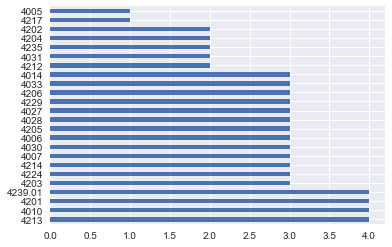

In [47]:
class_data['Census Tract'].value_counts().plot.barh()

We can write a short function, `bar_chart_column`, to plot the counts for any of our columns in the table. All we have to do is move the slider:

In [48]:
def bar_chart_column(column_num):
    bar_chart_data[bar_chart_data.columns[column_num]].value_counts().plot.barh()
    plt.title(bar_chart_data.columns[column_num])

## Removes student identification information, drop questions with checkboxes
bar_chart_data = class_data.iloc[:, 3:21].drop(
    'What kinds of establishments are there on the block face? Select all that apply.',
    axis = 1)

slider = widgets.IntSlider(min=0, max=14,step=1,value=0)
display(widgets.interactive(bar_chart_column, column_num=slider))

A Jupyter Widget

Some of the charts are small because there is so much text, try double-clicking the image to increase the size.

We can then ask for these columns and plot their means too. Again, you'll have to double click to zoom in:

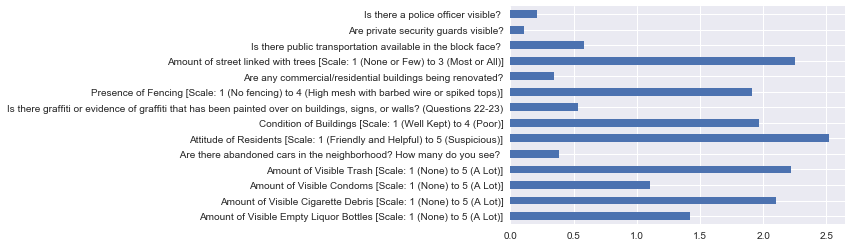

In [49]:
class_data.iloc[:, 4:22].mean().plot.barh()

One of the questions had checkbox answers that listed all of the establishments that were observed by each student in their assigned census tract. Let's create a seperate column for each of the possible options. A value of `1` in the column indicates that the estalishment was observed. A value of `0` indicates that the establishment was not observed.

In [50]:
establishments = pd.Series([item for sublist in [response.split(', ') for response in class_data.iloc[:, 18]] for item in sublist])

for establishment in establishments.unique():
    establishment_data = []

    for index, row in class_data.iterrows():
        ests = row['What kinds of establishments are there on the block face? Select all that apply.']
        row_establishments = ests.split(', ')
        if establishment in row_establishments:
            establishment_data.append(1)
        else: 
            establishment_data.append(0)
    
    
    class_data[establishment] = establishment_data
    
class_data.head().iloc[:,18:]

,What kinds of establishments are there on the block face? Select all that apply.,Banks or credit unions,Bars and alcoholic beverage services,Bodega deli corner-store convenience store,Community center,Eating places/restaurants,Fast food or take-out places,Gas station,Parks,Playgrounds,...,Schools or daycare centers,Police station,Supermarkets/grocery stores,Auto repair/auto body shop,Liquor stores or Marijuana Dispensaries,Warehouses,Payday lenders check cashers or pawn shops,Chain retail stores,Manufacturing,Fire station
0,"Banks or credit unions, Bars and alcoholic bev...",1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,"Parks, Playgrounds, Schools or daycare centers",0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2,Professional offices (doctor dentist lawyer ac...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Eating places/restaurants, Fast food or take-o...",0,0,0,0,1,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,Bodega deli corner-store convenience store,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


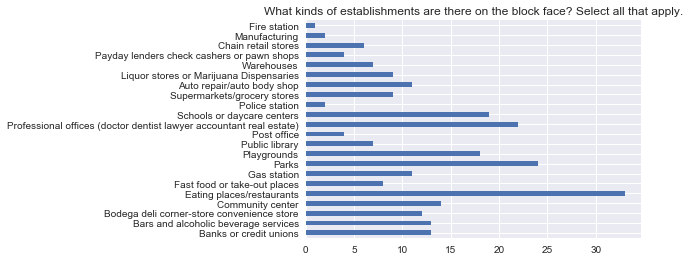

In [51]:
col_sums = []
for col in class_data.iloc[:, 19:].columns:
    col_sums.append(sum(class_data.iloc[:, 19:][col]))

establishment_counts = pd.Series(col_sums, index = class_data.iloc[:, 19:].columns)

establishment_counts.plot.barh()
plt.title(class_data.columns[18])
plt.show()

---

## Mapping

We can also visualize how your responses mapped out over the census tracts. We'll use a library called `folium` to map your observations onto a map of the census tracts, and include popups with your comments and photos.

In [52]:
alameda = geojson.load(open("data/alameda-2010.geojson"))
myMap = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)

map_data(myMap, alameda, image_data).save("map1.html")
IFrame('map1.html', width=700, height=400)

Click around census tracts near yours to see if the other students' observations are similar and see if you can eyeball any trends. Check out other areas on the map and see if there are trends for tracts in specific areas. Do specific characteristics cluster in different areas? Which ones? Which characteristsics seem to cluster together? What types of data do you think will correlate with socioeconomic characteristics like median income, poverty rate, education?  Why?

---

# Part 2: Our Metrics<a id='ourmetrics'></a>

Now that you have made some predictions, we can compare our data with socioeconomic data from the U.S. Census for the different tracts we visited and see if we can find evidence to support them. From your data, we can create some point scales that measure different aspects of a neighborhood.

For example, we can make a scale called “social disorder” for the first part of your responses. Let's first subeset our data:

In [54]:
social_disorder = class_data.iloc[:, 3:13]
social_disorder.head()

,Census Tract,Amount of Visible Empty Liquor Bottles [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Cigarette Debris [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Condoms [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Trash [Scale: 1 (None) to 5 (A Lot)],Are there abandoned cars in the neighborhood? How many do you see?,Attitude of Residents [Scale: 1 (Friendly and Helpful) to 5 (Suspicious)],Condition of Buildings [Scale: 1 (Well Kept) to 4 (Poor)],"Is there graffiti or evidence of graffiti that has been painted over on buildings, signs, or walls? (Questions 22-23)",Presence of Fencing [Scale: 1 (No fencing) to 4 (High mesh with barbed wire or spiked tops)]
0,4229,1,4,1,3,0,2,4,1,3
1,4201,1,1,1,1,0,1,1,0,1
2,4010,2,2,1,2,0,1,2,1,3
3,4033,1,2,1,1,0,3,2,0,1
4,4010,2,4,1,4,2,2,2,1,3


Now we'll need to scale the values because all responses were not on the same scale. But for this part, the higher the value the more negative the social disorder was:

In [55]:
social_disorder = scale_values(social_disorder, list(range(1,10)))
social_disorder.head()

,Census Tract,Amount of Visible Empty Liquor Bottles [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Cigarette Debris [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Condoms [Scale: 1 (None) to 5 (A Lot)],Amount of Visible Trash [Scale: 1 (None) to 5 (A Lot)],Are there abandoned cars in the neighborhood? How many do you see?,Attitude of Residents [Scale: 1 (Friendly and Helpful) to 5 (Suspicious)],Condition of Buildings [Scale: 1 (Well Kept) to 4 (Poor)],"Is there graffiti or evidence of graffiti that has been painted over on buildings, signs, or walls? (Questions 22-23)",Presence of Fencing [Scale: 1 (No fencing) to 4 (High mesh with barbed wire or spiked tops)]
0,4229,0.00,0.75,0.0,0.50,0.0,0.25,1.000000,1.0,0.666667
1,4201,0.00,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000
2,4010,0.25,0.25,0.0,0.25,0.0,0.00,0.333333,1.0,0.666667
3,4033,0.00,0.25,0.0,0.00,0.0,0.50,0.333333,0.0,0.000000
4,4010,0.25,0.75,0.0,0.75,0.5,0.25,0.333333,1.0,0.666667


Now that our values are scaled, we can take the mean across all observation for a given census tract for a given column, and then take the mean across columns:

In [56]:
social_disorder = pd.DataFrame(social_disorder.groupby("Census Tract").mean().mean(axis=1))
social_disorder.columns = ["Social Disorder"]
social_disorder

,Social Disorder
Census Tract,
4005,0.129630
4006,0.219136
4007,0.327160
4010,0.398148
4014,0.598765
4027,0.645062
4028,0.320988
4030,0.419753
4031,0.532407


Remember, the higher the value the more negative we perceived the census tract to be.

We can do the same for our amenities part:

In [57]:
amenities = class_data.iloc[:, [3] + [14] + list(range(19,41))]
amenities.head()

,Census Tract,Amount of street linked with trees [Scale: 1 (None or Few) to 3 (Most or All)],Banks or credit unions,Bars and alcoholic beverage services,Bodega deli corner-store convenience store,Community center,Eating places/restaurants,Fast food or take-out places,Gas station,Parks,...,Schools or daycare centers,Police station,Supermarkets/grocery stores,Auto repair/auto body shop,Liquor stores or Marijuana Dispensaries,Warehouses,Payday lenders check cashers or pawn shops,Chain retail stores,Manufacturing,Fire station
0,4229,2,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,4201,3,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,4010,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4033,2,0,0,0,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
4,4010,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Certain amenities are positive and indicate desirable conditions in a neighborhood. These characteristics include things like School or Daycares, and supermarkets. Let's create a Data Frame containing only positive amenities

In [58]:
positive_amentities = amenities[[
    'Census Tract',
    'Banks or credit unions',
    'Chain retail stores',
    'Community center',
    'Eating places/restaurants',
    'Fire station',
    'Parks',
    'Playgrounds',
    'Police station',
    'Public library',
    'Post office',
    'Professional offices (doctor dentist lawyer accountant real estate)',
    'Schools or daycare centers',
    'Supermarkets/grocery stores',
    'Amount of street linked with trees [Scale: 1 (None or Few) to 3 (Most or All)]'
]].rename(columns={'Amount of street linked with trees [Scale: 1 (None or Few) to 3 (Most or All)]': 'Trees'})

positive_amentities['Trees'] = [0 if tree_count == 0 else 1 for tree_count in positive_amentities['Trees']]

To make positive amenities comparable between census tracts, we can find the mean of positive amenities for each census tract. A higher value indicates a more positive census tract

In [59]:
positive_amentities = pd.DataFrame(positive_amentities.groupby("Census Tract").mean().mean(axis=1))
positive_amentities.columns = ["Positive Amenities"]
positive_amentities

,Positive Amenities
Census Tract,
4005,0.142857
4006,0.238095
4007,0.214286
4010,0.125000
4014,0.166667
4027,0.166667
4028,0.238095
4030,0.476190
4031,0.285714


Certain amenities are negative and indicate undesirable conditions in a neighborhood. These characteristics include things like Bars or Fast Food Restaurants. Let's create a Data Frame with only negative amenities

In [60]:
negative_amentities = amenities[[
    'Census Tract',
    'Auto repair/auto body shop',
    'Bars and alcoholic beverage services',
    'Bodega deli corner-store convenience store',
    'Fast food or take-out places',
    'Gas station',
    'Liquor stores or Marijuana Dispensaries',
    'Manufacturing' ,
    'Payday lenders check cashers or pawn shops',
    'Warehouses'
]]

To make negative amenities comparable between census tracts, we can find the mean of negative amenities for each census tract. A higher value indicates a more negative census tract

In [61]:
negative_amentities = pd.DataFrame(negative_amentities.groupby("Census Tract").mean().mean(axis=1))
negative_amentities.columns = ["Negative Amenities"]
negative_amentities

,Negative Amenities
Census Tract,
4005,0.111111
4006,0.074074
4007,0.333333
4010,0.194444
4014,0.222222
4027,0.259259
4028,0.037037
4030,0.222222
4031,0.055556


---

# Part 3: Census Data<a id='census'></a>

Let's read in some data for census tracts from the [American FactFinder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml):

In [62]:
official_data = pd.DataFrame.from_csv("data/merged-census.csv", index_col=None)
official_data['Census Tract'] = official_data["Census Tract"].apply(fix_tract)
official_data = official_data.set_index("Census Tract")
official_data

,Unemployment %,Household Median Income,Bachelor's Degree or higher %,% families with income under poverty line,% families with public assistance income,median house value,% white,% black,% asian,% hispanic/latino,% foreign born,% single mother family
Census Tract,,,,,,,,,,,,
4005,6.5,76038,61.9,6.1,4.5,611300.0,51.7,24.3,4.8,14.2,16.8,27.00
4006,14.9,60804,55.3,3.0,3.6,466700.0,34.8,38.7,6.5,12.3,13.0,25.00
4007,10.5,39614,40.9,14.5,1.2,572300.0,35.7,40.3,2.9,13.0,11.0,40.00
4010,9.2,44766,33.2,21.3,7.1,358100.0,31.4,38.5,4.3,19.6,12.2,41.00
4014,16.2,28532,18.6,34.6,11.8,333700.0,13.8,45.1,10.9,23.6,23.4,36.80
4027,8.3,40169,28.9,36.6,13.4,364300.0,27.3,45.7,8.2,16.4,11.0,41.80
4028,14.9,17278,33.8,27.1,6.3,517600.0,30.8,40.7,15.9,8.0,29.0,27.00
4030,12.6,17609,24.6,14.3,1.1,344700.0,6.8,2.4,85.2,2.5,68.8,17.80
4031,7.0,59250,38.5,25.4,0.9,386000.0,25.1,17.5,38.1,13.4,36.9,11.80


We can add our columns to this table to put it all in one place:

In [63]:
joined_data = official_data.join(social_disorder).join(positive_amentities).join(negative_amentities).reset_index()
joined_data

,Census Tract,Unemployment %,Household Median Income,Bachelor's Degree or higher %,% families with income under poverty line,% families with public assistance income,median house value,% white,% black,% asian,% hispanic/latino,% foreign born,% single mother family,Social Disorder,Positive Amenities,Negative Amenities
0,4005,6.5,76038,61.9,6.1,4.5,611300.0,51.7,24.3,4.8,14.2,16.8,27.00,0.129630,0.142857,0.111111
1,4006,14.9,60804,55.3,3.0,3.6,466700.0,34.8,38.7,6.5,12.3,13.0,25.00,0.219136,0.238095,0.074074
2,4007,10.5,39614,40.9,14.5,1.2,572300.0,35.7,40.3,2.9,13.0,11.0,40.00,0.327160,0.214286,0.333333
3,4010,9.2,44766,33.2,21.3,7.1,358100.0,31.4,38.5,4.3,19.6,12.2,41.00,0.398148,0.125000,0.194444
4,4014,16.2,28532,18.6,34.6,11.8,333700.0,13.8,45.1,10.9,23.6,23.4,36.80,0.598765,0.166667,0.222222
5,4027,8.3,40169,28.9,36.6,13.4,364300.0,27.3,45.7,8.2,16.4,11.0,41.80,0.645062,0.166667,0.259259
6,4028,14.9,17278,33.8,27.1,6.3,517600.0,30.8,40.7,15.9,8.0,29.0,27.00,0.320988,0.238095,0.037037
7,4030,12.6,17609,24.6,14.3,1.1,344700.0,6.8,2.4,85.2,2.5,68.8,17.80,0.419753,0.476190,0.222222
8,4031,7.0,59250,38.5,25.4,0.9,386000.0,25.1,17.5,38.1,13.4,36.9,11.80,0.532407,0.285714,0.055556
9,4033,8.9,57064,46.5,19.9,4.7,338300.0,26.2,9.0,54.9,4.7,52.5,24.10,0.154321,0.166667,0.074074


---

## Mapping Exploration

Before we quantify the relationship between the census data and our own metrics, let's do some exploratory mapping. We can now add our social disorder and amenities metrics to the popup too!

First we'll map a choropleth of unemployment:

In [64]:
mapa = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)
choropleth_overlay(mapa=mapa, column_name="Unemployment %", joined=joined_data, alameda=alameda).save("map2.html")
IFrame('map2.html', width=700, height=400)

Household Median Income:

In [65]:
mapb = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)
choropleth_overlay(mapa=mapb, column_name="Household Median Income", joined=joined_data, alameda=alameda).save("map3.html")
IFrame('map3.html', width=700, height=400)

Bachelor's Degree or higher %:

In [66]:
mapc = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)
choropleth_overlay(mapa=mapc, column_name="Bachelor's Degree or higher %", joined=joined_data, alameda=alameda).save("map4.html")
IFrame('map4.html', width=700, height=400)

Now our "social disorder":

In [67]:
mapd = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)
choropleth_overlay(mapa=mapd, column_name="Social Disorder", joined=joined_data, alameda=alameda).save("map5.html")
IFrame('map5.html', width=700, height=400)

Now "Positive Amenities":

In [68]:
mapa = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)
choropleth_overlay(mapa=mapa, column_name="Positive Amenities", joined=joined_data, alameda=alameda).save("map6.html")
IFrame('map6.html', width=700, height=400)

Finally, "Negative Amenities"

In [69]:
mapa = folium.Map(location=(37.8044, -122.2711), zoom_start=11.4)
choropleth_overlay(mapa=mapa, column_name="Negative Amenities", joined=joined_data, alameda=alameda).save("map7.html")
IFrame('map7.html', width=700, height=400)

What do you notice?

Try copying and pasting one of the mapping cells above and change the `column_name` variable to a different variable (column in our data) you'd like to map, then run the cell!

---

## Variable Distributions

We can also visualize the distributions of these variables according to census tract with [histograms](https://en.wikipedia.org/wiki/Histogram). A histogram will create bins, or ranges, within a variable and then count up the frequency for that bin. If we look at household median income, we may have bins of $10,000, and then we'd count how many tracts fall within that bin:

In [70]:
def viz_dist(var_name, tract):
    x = joined_data[var_name].dropna()
    reindexed = joined_data.set_index("Census Tract")
    
    plt.hist(x)
    plt.axvline(x=reindexed.loc[tract, var_name], color = "RED")
    plt.xlabel(var_name, fontsize=18)
    plt.show()

display(widgets.interactive(viz_dist, var_name=list(joined_data.columns[1:]), tract=list(joined_data["Census Tract"])))

A Jupyter Widget

What do these distributions tell you?

---


# Part 4: Correlation<a id='correlation'></a>

Let's first analyze income levels. We have sorted the data according to income level. Compare the income levels to the level of social disorder and amenities. Is there a correlation you can spot(as one increases or decreases, does the other do the same)?

In [ ]:
joined_data.sort_values("Household Median Income", ascending=False)[["Household Median Income", "Social Disorder", "Positive Amenities", "Negative Amenities"]]

Did you look at the whole table? A common mistake is to assume that since the top 10 results follow or do not follow a pattern, the rest don't. Real life data is often messy and not clean. Does the correlation continue throughout the whole table (a.k.a. as income decreases the points decrease) or is there no pattern? What does this mean about the data?

---

Eyeballing patterns is not the same as a statisical measure of a correlation; you must quantify it with numbers and statistics to prove your thoughts. Looking at the tables is not a very statistical measure of how much a variable correlates to the results. What does it mean for a variable "income" to match 7 out of the top 15 social disorder points? Does this correlate to the rest of the results? How well does it correlate? 

### The correlation coefficient - *r*

> The correlation coefficient ranges from −1 to 1. A value of 1 implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line for which Y increases as X increases. A value of −1 implies that all data points lie on a line for which Y decreases as X increases. A value of 0 implies that there is no linear correlation between the variables. ~Wikipedia

*r* = 1: the scatter diagram is a perfect straight line sloping upwards

*r* = -1: the scatter diagram is a perfect straight line sloping downwards.

Let's calculate the correlation coefficient between acceleration and price. We can use the `corr` method to generate a correlation matrix of our `joined_data`:

In [ ]:
joined_data.corr()

You'll notice that the matrix is mirrored with a `1.000000` going down the diagonal. This matrix yields the correlation coefficient for each variable to every other variable in our data.

For example, if we look at the `Social Disorder`, we see that there is a `.487102` correlation, implying that there is a strong positive relationship between our constructed social disorder variable and the unemployment rate (i.e., as one goes up the other goes up too). What else do you notice?

---



# Part 5: Regression<a id='regression'></a>

We will now use a method called linear regression to make a graph that will show the best fit line that correlates to the data. The slope of the line will show whether it is positively correlated or negatively correlated. The code that we've created so far has helped us establish a relationship between our two variables. Once a relationship has been established, it's time to create a model of the data. To do this we'll find the equation of the **regression line**!

The regression line is the **best fit** line for our data. It’s like an average of where all the points line up. In linear regression, the regression line is a perfectly straight line! Below is a picture showing the best fit line.

![image](http://onlinestatbook.com/2/regression/graphics/gpa.jpg)

As you can infer from the picture, once we find the **slope** and the **y-intercept** we can start predicting values! The equation for the above regression to predict university GPA based on high school GPA would look like this:

$UNIGPA_i= \alpha + \beta HSGPA + \epsilon_i$

The variable we want to predict (or model) is the left side `y` variable, the variable which we think has an influence on our left side variable is on the right side. The $\alpha$ term is the y-intercept and the $\epsilon_i$ describes the randomness.

We can set up a visualization to choose which variables we want as `x` and `y` and then plot the line of best fit:

In [ ]:
def f(x_variable, y_variable):
    
    if "median house value" in [x_variable, y_variable]:
        drop_na = joined_data.dropna()  # if not all census tracts have measure
        x = drop_na[x_variable]
        y = drop_na[y_variable]
        
    else:
        x = joined_data[x_variable]
        y = joined_data[y_variable]
    
    plt.scatter(x, y)
    plt.xlabel(x_variable, fontsize=18)
    plt.ylabel(y_variable, fontsize=18)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color="r") #calculate line of best fit
    plt.show()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) #gets the r_value
    print("R-squared: ", r_value**2)
    
display(widgets.interactive(f, x_variable=list(joined_data)[1:], y_variable=list(joined_data)[1:]))

***Note:*** The `R-squared` tells us how much of the variation in the data can be explained by our model.

Why is this a better method than just sorting tables? First of all, we are now comparing all of the data in the graph to the variable, rather than comparing what our eyes glance quickly over. It shows a more complete picture than just saying "There are some similar results in the top half of the sorted data". Second of all, the graph gives a more intuitive sense to see if your variable does match the data. You can quickly see if the data points match up with the regression line. Lastly, the r-squared value will give you a way to quantify how good the variable is to explain the data.

One of the beautiful things about computer science and statistics is that you do not need to reinvent the wheel. You don't need to know how to calculate the `R-squared` value, or draw the regression line; someone has already implemented it! You simply need to tell the computer to calculate it. However, if you are interested in these mathematical models, take a data science or statistics course!

---

***Please fill out our [feedback form](https://goo.gl/forms/PR1OQvX3bMIfype62)!***